<a href="https://colab.research.google.com/github/dcthyun0308/ESAA/blob/main/ESAA_YB_week13_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DBSCAN 개요

- 밀도 기반 군집화의 대표적인 알고리즘 DBSCAN - 데이터의 분포가 기하학적으로 복잡한 데이터 세트에도 효과적인 군집화가 가능

- DBSCAN을 구성하는 가장 중요한 두 가지 파라미터 : 입실론으로 표기하는 주변 영역, 입실론 주변 영역에 포함되는 최소 데이터의 개수

# - DBSCAN 적용하기 - 붓꽃 데이터 세트

- DBSCAN 클래스를 이용해 붓꽃 데이터 세트를 군집화하자.

In [1]:
from sklearn.datasets import load_iris
import pandas as pd

# Load the iris dataset
iris = load_iris()

# Create a DataFrame for iris data
irisDF = pd.DataFrame(data=iris.data, columns=iris.feature_names)

In [2]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: count, dtype: int64


- DBSCAN으로 군집화 데이터 세트를 2차원 평면에서 표현하기 위해 PCA를 이용해 2개의 피처로 압축 변환한 뒤, 앞 예제에서 사용한 visualize_cluster_plot() 함수를 이용해 시각화해 보자.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

%matplotlib inline

def visualize_cluster_plot(cluster_result=None, dataframe=None, label_name='target', iscenter=True):
    if dataframe is None:
        print("Error: DataFrame is required.")
        return

    unique_labels = np.unique(dataframe[label_name])
    markers = ['o', 's', '^', 'x', '*', 'D', '+', 'v', '<', '>']

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name] == label]
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k',
                    marker=markers[label % len(markers)])

        if iscenter and cluster_result is not None and hasattr(cluster_result, 'cluster_centers_'):
            # Assuming cluster_result has a .cluster_centers_ attribute
            center_x_y = cluster_result.cluster_centers_[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9,
                        marker=markers[label % len(markers)])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k',
                        marker='' % label)
    plt.show()

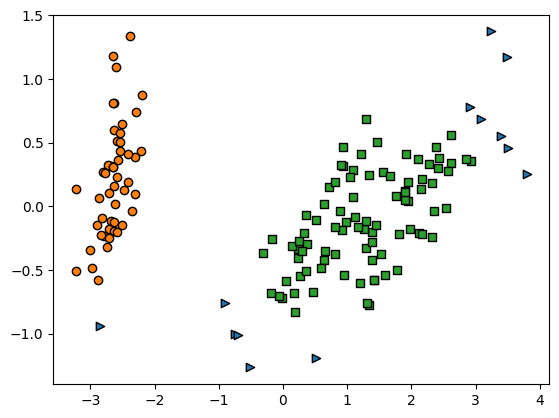

In [4]:
from sklearn.decomposition import PCA
# 2차원으로 시각화하기 위해 PCA n_components=2로 피처 데이터 세트 변환
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(iris.data)
# visualize_cluster_plot() 함수는 ftr1, ftr2 칼럼을 좌표에 표현하므로 PCA 변환값을 해당 칼럼으로 생성
irisDF['ftr1'] = pca_transformed[:,0]
irisDF['ftr2'] = pca_transformed[:,1]

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

- eps를 기존의 0.6에서 0.8로 증가시키면 노이즈 데이터 수가 줄어듦. 다음 예제 코드로 확인해 보자.

target  dbscan_cluster
0        0                50
1        1                50
2        1                47
        -1                 3
Name: count, dtype: int64


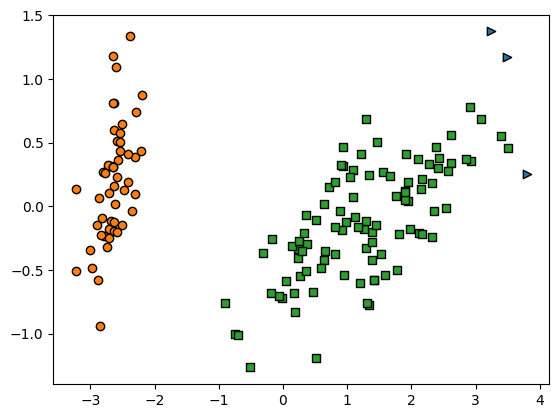

In [5]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

- eps를 기존 0.6으로 유지하고 min_samples를 16으로 늘려보자. 바로 위 예제 코드에서 DBSCAN의 초기화 파라미터 값만 다음과 같이 변경하면 됨.

In [6]:
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')

# - DBSCAN 적용하기 - make_circles() 데이터 세트

- 복잡한 기하학적 데이터 분포를 가지는 데이터 세트에서 DBSCAN과 타 알고리즘을 비교해 보자.

- 먼저 make_circles() 함수를 이용해 내부 원과 외부 원 형태로 돼 있는 2차원 데이터 세트를 만들어 보자.

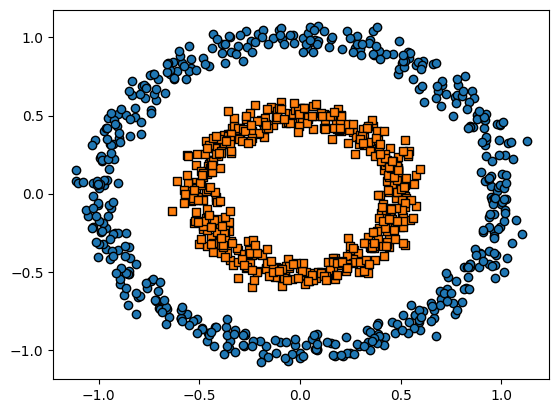

In [7]:
from sklearn.datasets import make_circles

X, y =make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=0, factor=0.5)
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

- K-평균으로 make_circles() 데이터 세트를 군집화해보자.

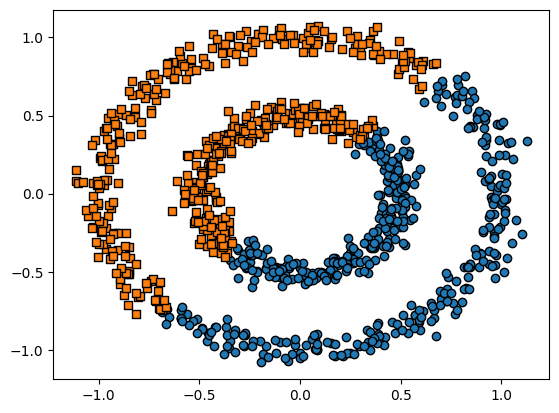

In [8]:
# KMeans로 make_circles() 데이터 세트를 군집화 수행.
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels = kmeans.fit_predict(X)
clusterDF['kmeans_cluster'] = kmeans_labels

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=False)

- GMM을 적용해 보자.

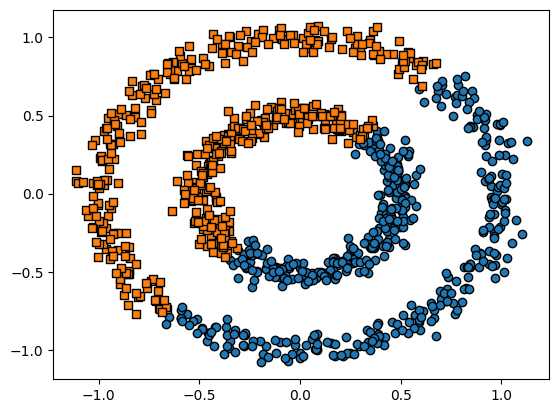

In [9]:
# GMM으로 make_circles() 데이터 세트를 군집화 수행.
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=0)
gmm_label = gmm.fit(X).predict(X)
clusterDF['gmm_cluster'] = gmm_label

visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)

- DBSCAN으로 군집화를 적용해 보자.

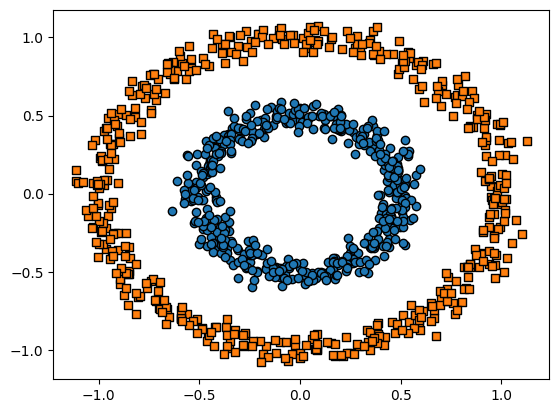

In [10]:
# DBSCAN으로 make_circles() 데이터 세트 군집화 수행.
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clusterDF['dbscan_cluster'] = dbscan_labels
visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)

# 6. 군집화 실습 - 고객 세그먼테이션

# - 고객 세그먼테이션의 정의와 기법

- 고객 세그먼테이션은 다양한 기준으로 고객을 분류하는 기법. CRM이나 마케팅의 중요 기반 요소.

# - 데이터 세트 로딩과 데이터 클렌징

- 엑셀 파일을 판다스의 read_excel() 함수를 이용해 DataFrame으로 로드해 보자.

In [11]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel(io='Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


- 데이터 세트의 전체 건수, 칼럼 타입, Null 개수를 확인해 보자.

In [12]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


- 불린 인덱싱을 적용해 Quantity > 0, UnitPrice > 0 이고 CustomerID이 Not Null인 값만 다시 필터링하자.

In [13]:
retail_df = retail_df[retail_df['Quantity']>0]
retail_df = retail_df[retail_df['UnitPrice']>0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [14]:
retail_df['Country'].value_counts()[:5]

,count
Country,
United Kingdom,354321
Germany,9040
France,8341
EIRE,7236
Spain,2484


- 영국이 대다수를 차지하므로 다른 국가의 데이터는 모두 제외하자.

In [15]:
retail_df = retail_df[retail_df['Country'] == 'United Kingdom']
print(retail_df.shape)

(354321, 8)


# - RFM 기반 데이터 가공

- 먼저 'UnitPrice'와 'Quantity'를 곱해서 주문 금액 데이터를 만들자. 그리고 CustomerNo도 더 편리한 식별성을 위해 float 형을 int 형으로 변경하자.

In [16]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

- Top-5 주문 건수와 주문 금액을 가진 고객 데이터를 추출해 보자.

In [17]:
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

CustomerID
17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: count, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [18]:
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count().mean()

np.float64(1.028702077315023)

- 지금 수행하려는 RFM 기반의 고객 세그먼테이션은 고객 레벨로 주문 기간, 주문 횟수, 주문 금액 데이터를 기반으로 해 세그먼테이션을 수행하는 것. 이에 주문번호+상품코드 기준의 데이터를 고객 기준의 Recency, Frequency, Monetary value 데이터로 변경하자. 이를 위해서는 주문번호 기준의 데이터를 개별 고객 기준의 데이터로 Group by를 해야 함.

In [19]:
# DataFrame의 groupby()의 multiple 연산을 위해 agg() 이용
# Recenvy는 InvoiceDate 칼럼의 max()에서 데이터 가공
# Frequency는 InvoiceNo 칼럼의 count(), Monetary value는 sale_anount 칼럼의 sum()
aggregations = {
    'InvoiceDate': 'max',
    'InvoiceNo': 'count',
    'sale_amount': 'sum'
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 칼럼 값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'
                                    }
                         )
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


- 가장 최근의 주문 일자를 뺀 데이터에서 일자 데이터만 추출해 생성하자.

In [20]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011, 12, 10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 칼럼 건수는', cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는 (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


# - RFM 기반 고객 세그먼테이션

- 왜곡된 데이터 분포도에서 군집화를 수행할 때 어떤 현상이 발생하는지 알아보자.

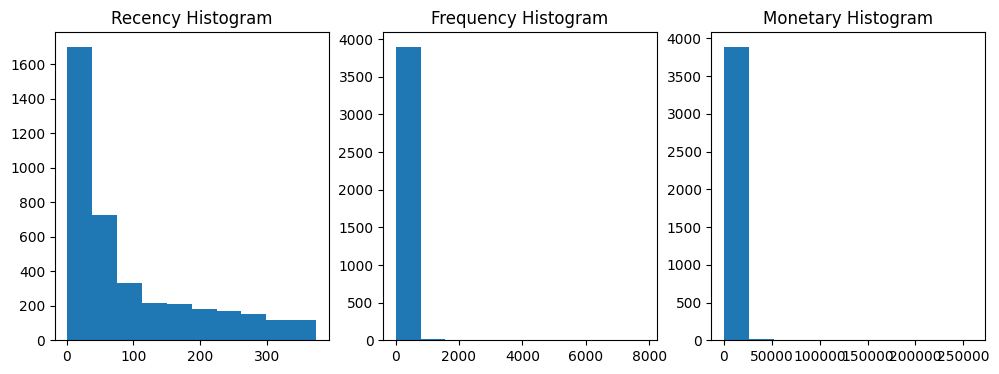

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])
plt.show()

- 각 칼럼의 데이터 값 백분위로 대략적으로 어떻게 값이 분포돼 있는지 확인하자.

In [22]:
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


- 데이터 세트를 StandardScaler로 평균과 표준편차를 재조정한 뒤에 K-평균을 수행해 보자.

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는 : 0.576


In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

def visualize_silhouette(cluster_lists, X_features):
    # Visualize Silhouette for each cluster_lists
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)

    for ind, n_cluster in enumerate(cluster_lists):
        kmeans = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0, n_init='auto')
        cluster_labels = kmeans.fit_predict(X_features)

        silhouette_avg = silhouette_score(X_features, cluster_labels)
        sample_silhouette_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : ' + str(n_cluster) + '\n' \
                           'Silhouette Score :' + str(round(silhouette_avg, 3)))
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, \
                                   facecolor=color, edgecolor=color, alpha=0.7)

            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.tight_layout()
    plt.show()

def visualize_kmeans_plot_multi(cluster_lists, X_features, iscenter=False):
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)

    pca = PCA(n_components=2, random_state=0)
    pca_transformed = pca.fit_transform(X_features)

    dataframe = pd.DataFrame(data=pca_transformed, columns=['ftr1', 'ftr2'])

    markers = ['o', 's', '^', 'x', '*', 'D', '+', 'v', '<', '>']

    for ind, n_cluster in enumerate(cluster_lists):
        kmeans = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0, n_init='auto')
        cluster_labels = kmeans.fit_predict(X_features)
        dataframe['cluster'] = cluster_labels

        unique_labels = np.unique(dataframe['cluster'])

        for label in unique_labels:
            label_cluster = dataframe[dataframe['cluster'] == label]
            axs[ind].scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k',
                             marker=markers[label % len(markers)])

        if iscenter and hasattr(kmeans, 'cluster_centers_'):
            center_x_y = pca.transform(kmeans.cluster_centers_)
            for label, center in enumerate(center_x_y):
                axs[ind].scatter(x=center[0], y=center[1], s=200, color='gray', alpha=0.9,
                                 marker=markers[label % len(markers)])
                axs[ind].scatter(x=center[0], y=center[1], s=70, color='k', edgecolor='k',
                                 marker='' % label)

        axs[ind].set_title('Number of Cluster : ' + str(n_cluster))
        axs[ind].set_xlabel('ftr1')
        axs[ind].set_ylabel('ftr2')

    plt.tight_layout()
    plt.show()

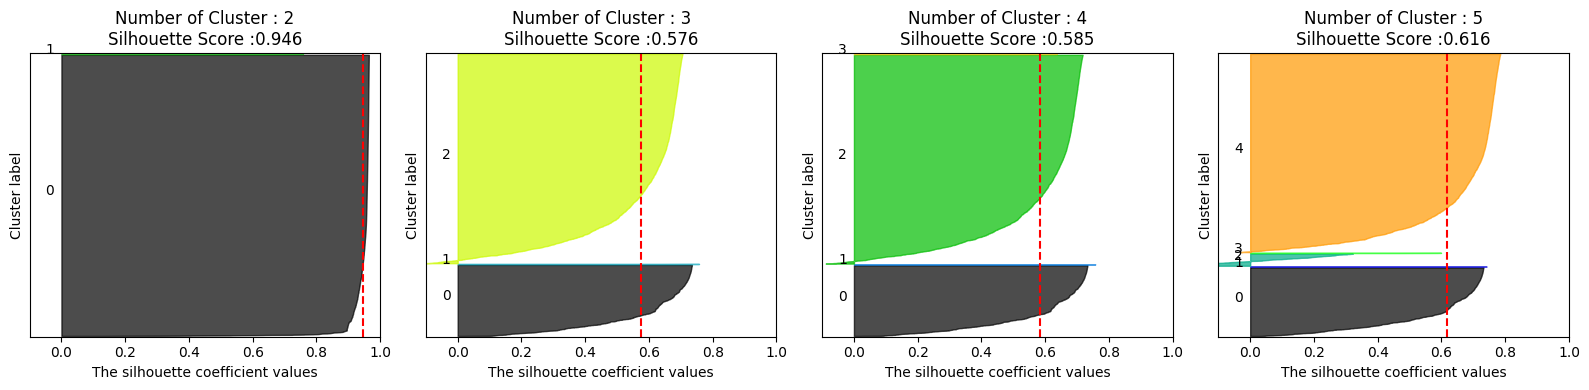

/tmp/ipython-input-3424543561.py:70: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k',
/tmp/ipython-input-3424543561.py:70: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k',


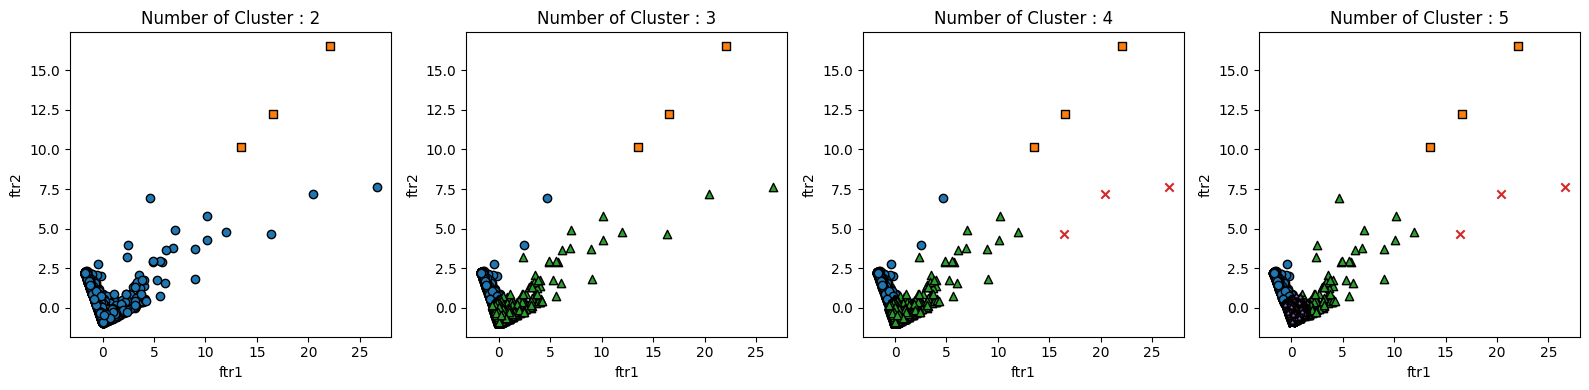

In [25]:
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

- 데이터 세트의 왜곡 정도를 낮추기 위해 가장 자주 사용되는 방법은 데이터 값에 로그(Log)를 적용하는 로그 변환임. 온라인 판매 데이터 세트의 왜곡 정도를 낮추기 위해서 전체 데이터를 로그 변환한 뒤에 K-평균 알고리즘을 적용하고 결과를 비교해 보자.

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequency, Monetary 칼럼에 np.log1p()로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는 : 0.303


-  실루엣 스코어는 로그 변환하기 전보다 떨어지지만 앞의 경우보다 더 균일하게 군집화가 구성됐음을 위 그림을 통해 알 수 있음. 이처럼 왜곡된 데이터 세트에 대해서는 로그 변환으로 데이터를 일차 변환한 후에 군집화를 수행하면 더 나은 결과를 도출할 수 있음.